In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

In [2]:
## Find all .csv in specified directory
# directory path
dir = r"project_datasets\\"
# glob finds and puts all the file paths into a list
all_files = glob.glob(dir + "*.csv")

In [3]:
## Using RegEx take the name and format it (Format => "df_A")
pattern = re.compile(r'(?<=\\)(.*?)(?=\.)')
def get_file_names(x):
    files = x
    saved = []
    for file in files:
        for name in re.findall(pattern, file):
            name = name.replace("data","df")
            ## .lower() could be removed it's just that our existing document uses lower case (df_a, df_d)
            name = name.lower()
            saved.append(name)
    return saved

In [4]:
## Read all the file name and paths and assign them to variable
dataframe_names = get_file_names(all_files)
for index, item in enumerate(dataframe_names):
    globals()['%s' % item] = pd.read_csv(all_files[index])


In [5]:
print("Available Dataframes:")
print(dataframe_names)

Available Dataframes:
['df_a', 'df_aa', 'df_ab', 'df_ac', 'df_ad', 'df_b', 'df_c', 'df_d', 'df_e', 'df_f', 'df_g', 'df_h', 'df_i', 'df_j', 'df_k', 'df_m', 'df_n', 'df_o', 'df_p', 'df_q', 'df_r', 'df_s', 'df_t', 'df_u', 'df_v', 'df_w', 'df_x', 'df_y', 'df_z']


In [6]:
## Convert all column types to date_time and transform dataframes to time-series
for item in dataframe_names:
    globals()['%s' % item]["EventDt"] = pd.to_datetime(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].set_index(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].resample(rule="5T").mean()

In [7]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:10:00 to 2021-11-18 16:00:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    258390 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [8]:
## Added additional dataframes with resampled data in different formats (daily, weekly, monthly)
for item in dataframe_names:
    globals()['%s_daily' % item] = globals()['%s' % item].resample(rule="D").mean()
    globals()['%s_weekly' % item] = globals()['%s' % item].resample(rule="W").mean()
    globals()['%s_monthly' % item] = globals()['%s' % item].resample(rule="M").mean()

In [9]:
average_temps = []
for item in dataframe_names:
#     mean_temp = globals()['%s' % item]["Temp"].mean()
    mean_temp = globals()['%s' % item]["Temp"].quantile(.35)
    average_temps.append(mean_temp)
    
mean_temp_dev_dictionary = {"Device":dataframe_names,"Mean Temperature":average_temps}
mean_temp_dev = pd.DataFrame.from_dict(mean_temp_dev_dictionary)
mean_temp_dev.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Device,df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,...,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z
Mean Temperature,17.33,-21.0,18.83,21.87,19.41,5.55,14.15,16.84,-24.13,21.75,...,18.89,4.53,0.96,13.0,19.53,4.14,6.36,5.19,-21.1,5.54


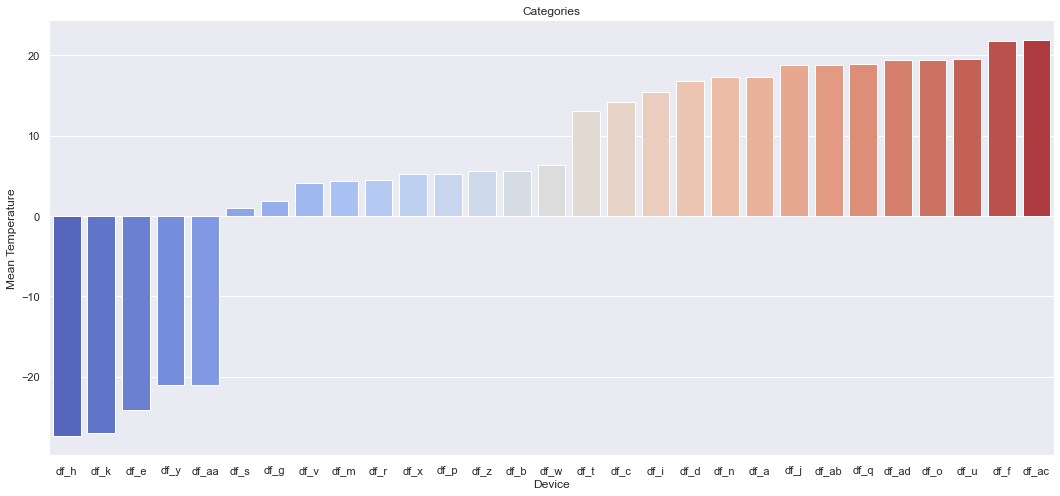

In [10]:
#sns.set_theme(style="whitegrid")
#sns.set_palette(sns.color_pallete("icefire"),as_cmap=True)
sns.set(rc={'figure.figsize':(18,8)})
sns.barplot(x="Device", 
            y="Mean Temperature", 
            data=mean_temp_dev,
            order=mean_temp_dev.sort_values('Mean Temperature').Device,
            palette = "coolwarm").set(title='Categories')
plt.show()

In [11]:
## If the code is confusing TLDR:
## - All dataframes are imported (df_a,df_aa, etc...)
## - mean_temp_dev dataframe has the names of all dataframes and their average temperature

In [12]:
#barchart per category
#check the order
mean_temp_dev.sort_values(by='Mean Temperature',ascending=True).T

,11,14,8,27,1,21,10,24,15,20,...,16,0,13,2,19,4,17,23,9,3
Device,df_h,df_k,df_e,df_y,df_aa,df_s,df_g,df_v,df_m,df_r,...,df_n,df_a,df_j,df_ab,df_q,df_ad,df_o,df_u,df_f,df_ac
Mean Temperature,-27.33,-26.97,-24.13,-21.1,-21.0,0.96,1.91,4.14,4.37,4.53,...,17.24,17.33,18.83,18.83,18.89,19.41,19.43,19.53,21.75,21.87


In [13]:
#categories
categories = []
for value in mean_temp_dev['Mean Temperature']:
    if value < 0: categories.append('Freezer')
    elif 0 <= value < 10: categories.append('Fridge')
    elif 10 <= value :categories.append('Pantry')
    else: categories.append('unknown')
        
mean_temp_dev['Categories']  = categories
mean_temp_dev.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Device,df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,...,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z
Mean Temperature,17.33,-21.0,18.83,21.87,19.41,5.55,14.15,16.84,-24.13,21.75,...,18.89,4.53,0.96,13.0,19.53,4.14,6.36,5.19,-21.1,5.54
Categories,Pantry,Freezer,Pantry,Pantry,Pantry,Fridge,Pantry,Pantry,Freezer,Pantry,...,Pantry,Fridge,Fridge,Pantry,Pantry,Fridge,Fridge,Fridge,Freezer,Fridge


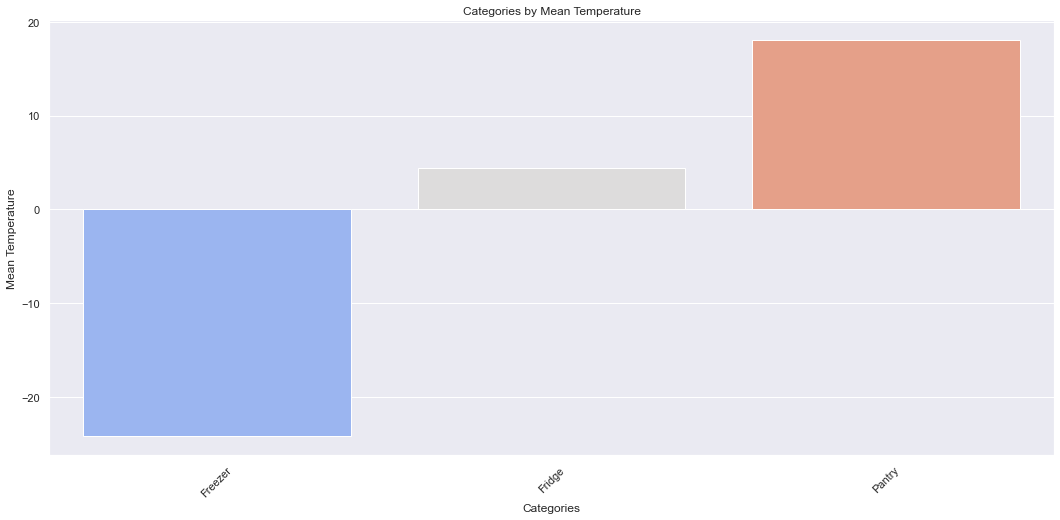

In [14]:
#barchart per group
sns.barplot(data=mean_temp_dev,
                x="Categories",
                y="Mean Temperature",
                palette = "coolwarm",
                ci=None,
                order=["Freezer", "Fridge","Pantry"])
plt.title('Categories by Mean Temperature')
plt.xticks(rotation=45)
plt.show()

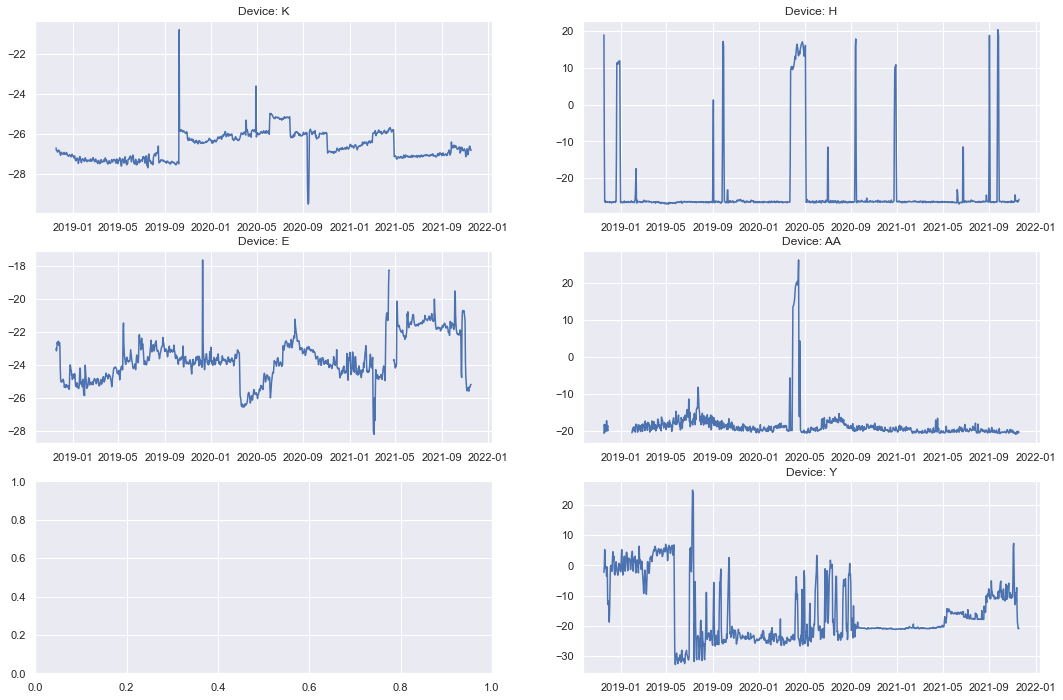

In [15]:
#freezer
#pic size
fig, axes = plt.subplots(3,2, figsize=(18,12))
#fix the date and maybe zoom in or smt
axes[0,0].plot(df_k_daily["Temp"])
axes[0,1].plot(df_h_daily["Temp"])
axes[1,0].plot(df_e_daily["Temp"])
axes[1,1].plot(df_aa_daily["Temp"])
axes[2,1].plot(df_y_daily["Temp"])
axes[0,0].set_title('Device: K')
axes[0,1].set_title('Device: H')
axes[1,0].set_title('Device: E')
axes[1,1].set_title('Device: AA')
axes[2,1].set_title('Device: Y')
plt.show()

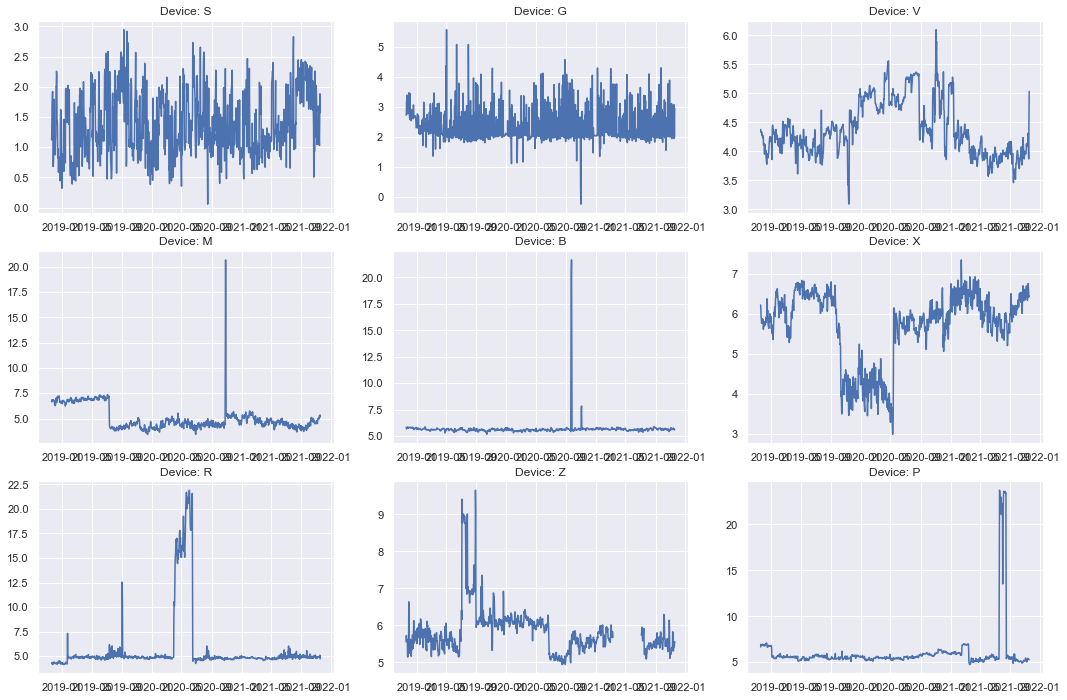

In [16]:
#refrigerator
#pic size
fig, axes = plt.subplots(3,3, figsize=(18,12))
#fix the date and maybe zoom in or smt
axes[0,0].plot(df_s_daily["Temp"])
axes[0,1].plot(df_g_daily["Temp"])
axes[0,2].plot(df_v_daily["Temp"])
axes[1,0].plot(df_m_daily["Temp"])
axes[1,1].plot(df_b_daily["Temp"])
axes[1,2].plot(df_x_daily["Temp"])
axes[2,0].plot(df_r_daily["Temp"])
axes[2,1].plot(df_z_daily["Temp"])
axes[2,2].plot(df_p_daily["Temp"])
axes[0,0].set_title('Device: S')
axes[0,1].set_title('Device: G')
axes[0,2].set_title('Device: V')
axes[1,0].set_title('Device: M')
axes[1,1].set_title('Device: B')
axes[1,2].set_title('Device: X')
axes[2,0].set_title('Device: R')
axes[2,1].set_title('Device: Z')
axes[2,2].set_title('Device: P')
plt.show()

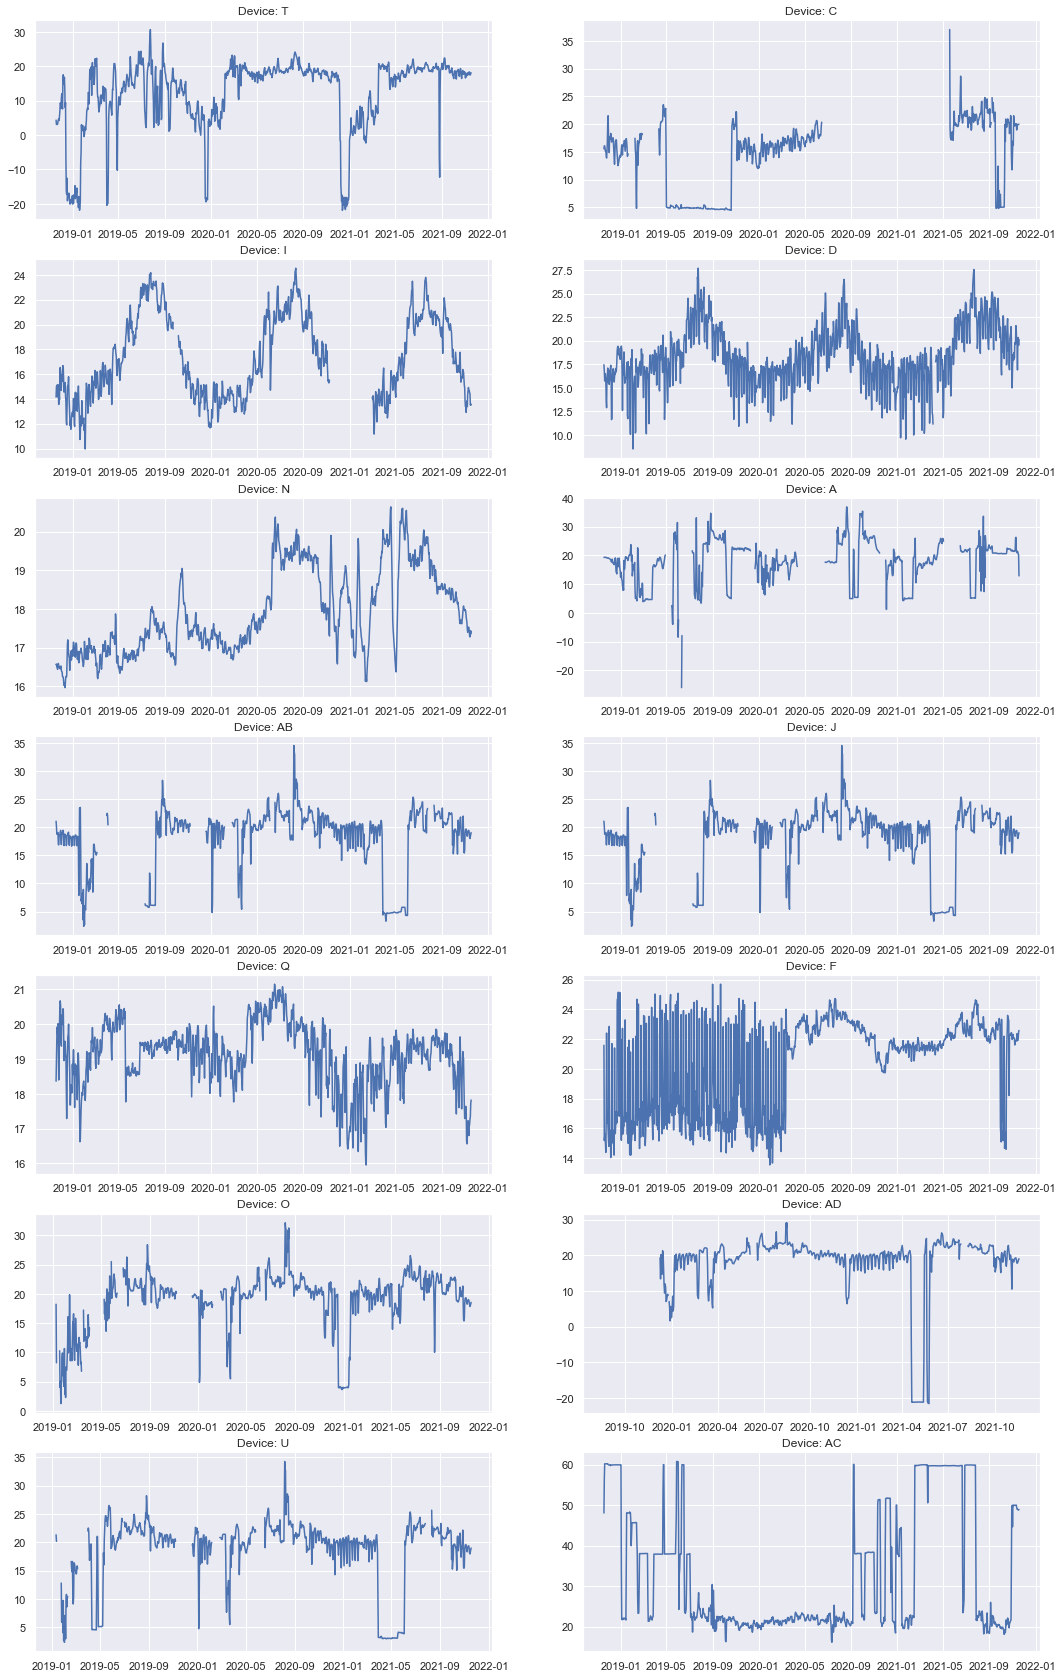

In [17]:
fig, axes = plt.subplots(7,2, figsize=(18,30))
axes[0,0].plot(df_t_daily["Temp"])
axes[0,1].plot(df_c_daily["Temp"])
axes[1,0].plot(df_i_daily["Temp"])
axes[1,1].plot(df_d_daily["Temp"])
axes[2,0].plot(df_n_daily["Temp"])
axes[2,1].plot(df_a_daily["Temp"])
axes[3,0].plot(df_ab_daily["Temp"])
axes[3,1].plot(df_j_daily["Temp"])
axes[4,0].plot(df_q_daily["Temp"])
axes[4,1].plot(df_f_daily["Temp"])
axes[5,0].plot(df_o_daily["Temp"])
axes[5,1].plot(df_ad_daily["Temp"])
axes[6,0].plot(df_u_daily["Temp"])
axes[6,1].plot(df_ac_daily["Temp"])
axes[0,0].set_title('Device: T')
axes[0,1].set_title('Device: C')
axes[1,0].set_title('Device: I')
axes[1,1].set_title('Device: D')
axes[2,0].set_title('Device: N')
axes[2,1].set_title('Device: A')
axes[3,0].set_title('Device: AB')
axes[3,1].set_title('Device: J')
axes[4,0].set_title('Device: Q')
axes[4,1].set_title('Device: F')
axes[5,0].set_title('Device: O')
axes[5,1].set_title('Device: AD')
axes[6,0].set_title('Device: U')
axes[6,1].set_title('Device: AC')
plt.show()

In [18]:
## Freezer k, aa, h
## Fridge b, s ,g
## Pantry i, d, ab

In [19]:
## 3 devices for 3 categories
## do all Boxplots
## Zoomie Zoomie 2 Weeks
## See parterns 
## Analyze more

## Freezer

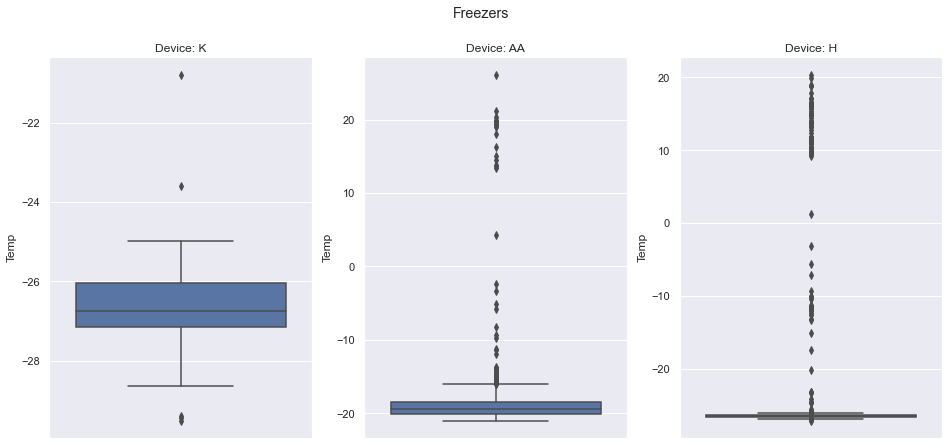

In [20]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Freezers')
sns.boxplot(ax=axes[0],y="Temp",data=df_k_daily)
sns.boxplot(ax=axes[1],y="Temp",data=df_aa_daily)
sns.boxplot(ax=axes[2],y="Temp",data=df_h_daily)
axes[0].set_title('Device: K')
axes[1].set_title('Device: AA')
axes[2].set_title('Device: H')
plt.show()

## Fridge

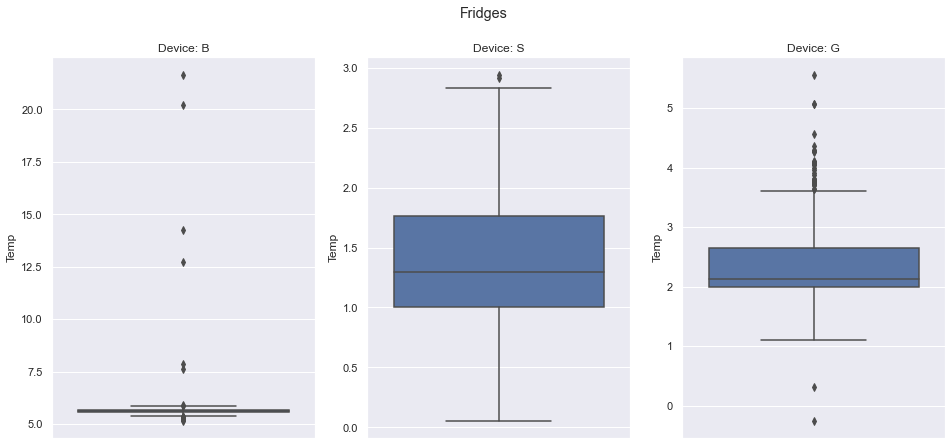

In [21]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Fridges')
sns.boxplot(ax=axes[0],y="Temp",data=df_b_daily)
sns.boxplot(ax=axes[1],y="Temp",data=df_s_daily)
sns.boxplot(ax=axes[2],y="Temp",data=df_g_daily)
axes[0].set_title('Device: B')
axes[1].set_title('Device: S')
axes[2].set_title('Device: G')
plt.show()

## Pantry

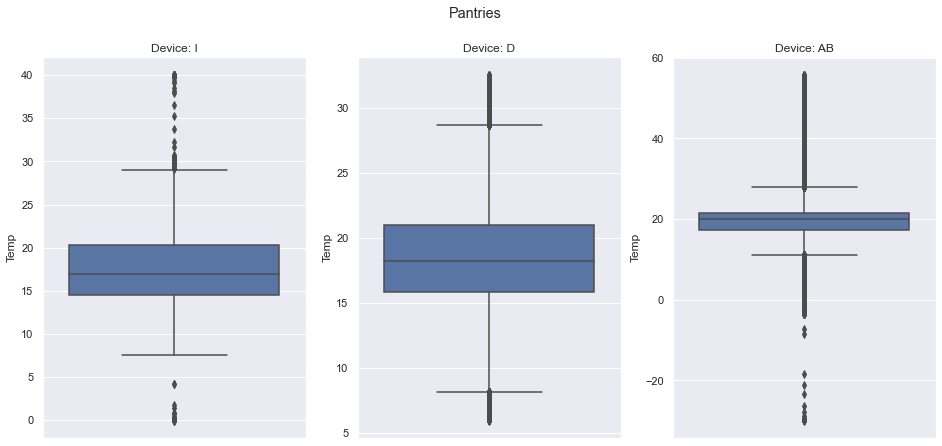

In [22]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Pantries')
sns.boxplot(ax=axes[0],y="Temp",data=df_i)
sns.boxplot(ax=axes[1],y="Temp",data=df_d)
sns.boxplot(ax=axes[2],y="Temp",data=df_ab)
axes[0].set_title('Device: I')
axes[1].set_title('Device: D')
axes[2].set_title('Device: AB')
plt.show()

# Zoom

In [23]:
## Zoom Dataframes were added:
#    - df_[id]_daily
#    - df_[id]_weekly
#    - df_[id]_monthly

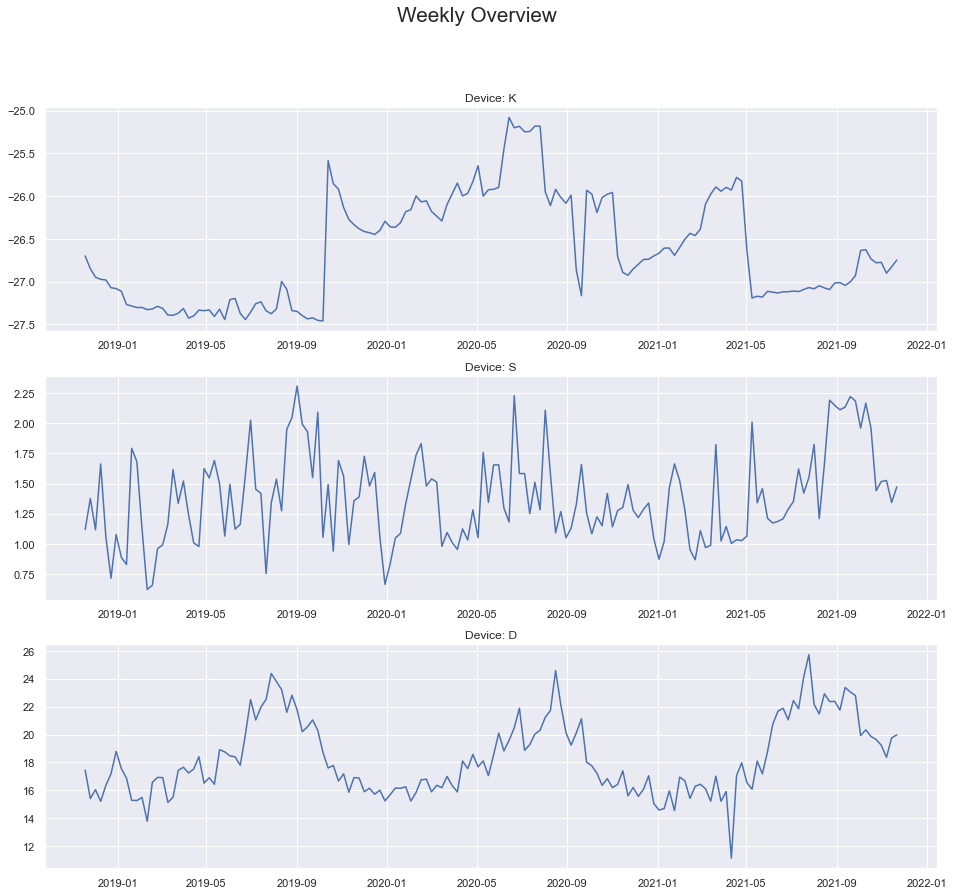

In [24]:
fig, axes = plt.subplots(3, figsize=(16,14))
fig.suptitle('Weekly Overview',fontsize="xx-large")
axes[0].plot(df_k_weekly)
axes[1].plot(df_s_weekly)
axes[2].plot(df_d_weekly)
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: D')
plt.show()

## Hourly Zoom

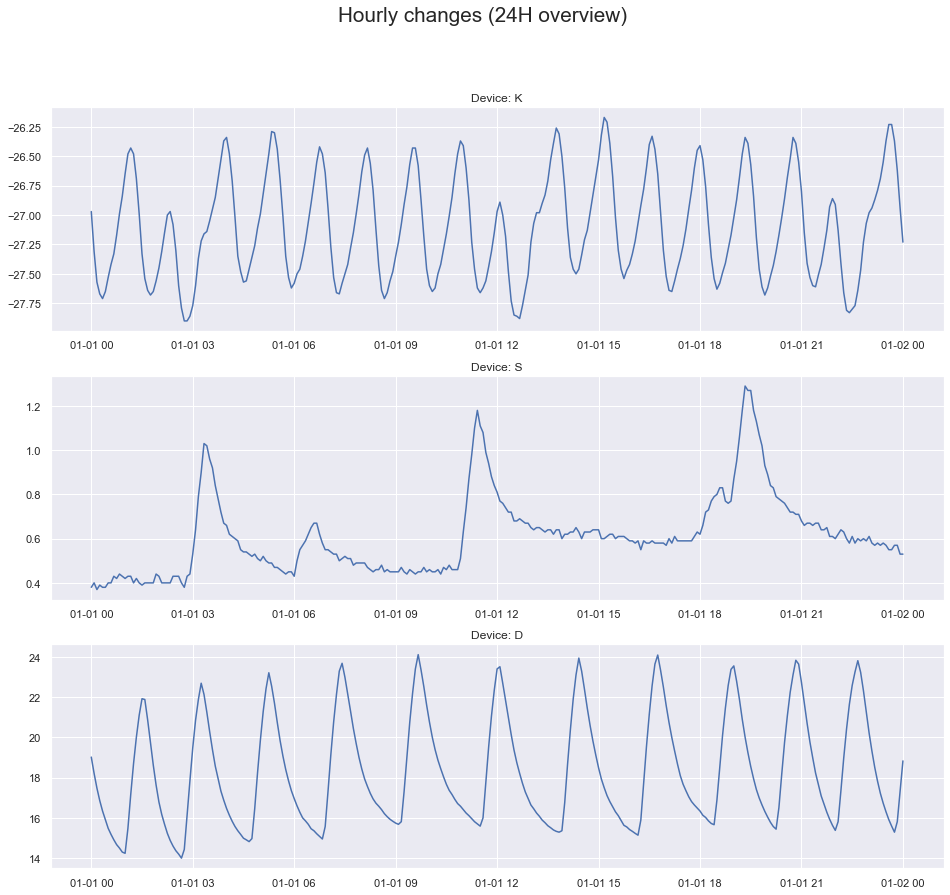

In [25]:
df_k_zoom = df_k.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]
df_s_zoom = df_s.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]
df_d_zoom = df_d.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(3, figsize=(16,14))
fig.suptitle('Hourly changes (24H overview)',fontsize="xx-large")
axes[0].plot(df_k_zoom)
axes[1].plot(df_s_zoom)
axes[2].plot(df_d_zoom)
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: D')
plt.show()